In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import hmp
from mne.io import read_info
import warnings
import pandas as pd
from utils import latency_model_fit, r_squared
import bambi as bmb
import arviz as az
from scipy.stats import gamma
from mne.viz import plot_topomap
from scipy.signal import windows
from mne.stats import permutation_cluster_1samp_test
from matplotlib.lines import Line2D 

eeg_data_path = os.path.join('data','preprocessed/')#Declaring path where the eeg data is
subj_names = [x.split('.')[0] for x in os.listdir(eeg_data_path) if '.fif' in x]#Extracting subject name based on the file name
subj_files = [eeg_data_path+x+'.fif' for x in subj_names]#Create a list of files that can be read from the folder

# Load sensor position for an example participants (assumes all have the same channel position)
info = read_info(subj_files[0], verbose=True)

sfreq = info['sfreq'] #at what sampling rate we want the data, replace with 100Hz for speed/RAM
tstep = (1000/sfreq) #Time step for plotting

# REad epoch data but ignore RT
epoch_data = hmp.io.read_mne_data(subj_files, epoched=True, sfreq=sfreq, 
                                     verbose=False,
                                     subj_idx=subj_names,
                                     ignore_rt=True)
# REcover estiation
model = hmp.io.load_model('estimation_files/model')
estimates = hmp.io.load_model('estimation_files/estimates')

Processing participant data/preprocessed/6_epo.fif's epoched eeg
1116 trials were retained for participant data/preprocessed/6_epo.fif
Processing participant data/preprocessed/19_epo.fif's epoched eeg
1116 trials were retained for participant data/preprocessed/19_epo.fif
Processing participant data/preprocessed/20_epo.fif's epoched eeg
1116 trials were retained for participant data/preprocessed/20_epo.fif
Processing participant data/preprocessed/10_epo.fif's epoched eeg
1116 trials were retained for participant data/preprocessed/10_epo.fif
Processing participant data/preprocessed/0_epo.fif's epoched eeg
1116 trials were retained for participant data/preprocessed/0_epo.fif
Processing participant data/preprocessed/11_epo.fif's epoched eeg
1116 trials were retained for participant data/preprocessed/11_epo.fif
Processing participant data/preprocessed/23_epo.fif's epoched eeg
1116 trials were retained for participant data/preprocessed/23_epo.fif
Processing participant data/preprocessed/14_e

In [2]:
data = epoch_data.stack({'trial_x_participant':['participant','epochs']}).data.dropna('trial_x_participant', how="all")
times_sp = hmp.utils.event_times(estimates, mean=False, add_rt=True, add_stim=True)#utils.compute_times(init, estimates, mean=True, add_rt=True, as_time=True)

weights =  hmp.utils.event_topo(epoch_data, estimates, mean=True)#init.compute_topographies(epoch_data, estimates, init)#0 is first event

tstep = 1000/sfreq 
name_sat = {'speed':'Speed','accuracy':'Accuracy'}
ax_sat = {"speed":0, "accuracy":1}
# avg_sat = {"accuracy":avg_accuracy, "speed":avg}
channels = info['ch_names'][:32]
decision_event = 2

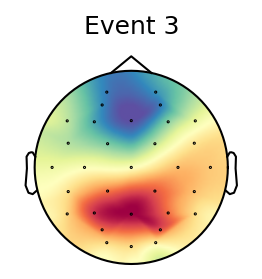

In [3]:
fig, ax = plt.subplots(1,1, dpi=150, figsize=(2,2))
plot_topomap(weights.sel(event=decision_event).values[:,0], info, sensors=True, cmap='Spectral_r', res=100, show=False, axes=ax, contours=False)
ax.set_title(f'Event {decision_event+1}')
fig.savefig('plots/topo.png', transparent=True, dpi=300)


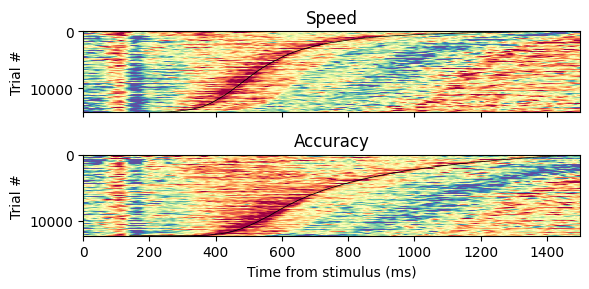

In [4]:
def gauss_window(sorted_mvp):
    gauss_k = windows.gaussian(50, 20)

    #convolve
    x = np.zeros(sorted_mvp.shape)*np.nan
    for t in range(sorted_mvp.shape[1]):
        x[:,t] = np.convolve(sorted_mvp[:,t], gauss_k, mode="same")
    # Zscore
    x = (x-np.tile(np.nanmean(x, axis=1), (x.shape[1], 1)).T)\
            /np.tile(np.nanstd(x, axis=1), (x.shape[1], 1)).T
    return x

n_samples = 1.5*sfreq
fig, ax = plt.subplots(2,figsize=(6, 3))
for SAT in ['accuracy','speed']:
    data_left_sp = data.where((data.condition == SAT), drop=True).dropna('trial_x_participant', how="all")

    #Used for RTs
    centered_rt = hmp.utils.centered_activity(data_left_sp, times_sp, channels,
                    event=0, n_samples=n_samples, cut_before_event=0, cut_after_event=4,
                    baseline=0)
    #Actual mvp values
    centered_surface = hmp.utils.centered_activity(data_left_sp, times_sp, channels,
                    event=0, n_samples=n_samples, cut_before_event=0, cut_after_event=0,
                    baseline=0)
    rts_surface = np.isnan(centered_rt.data.sel(channel='Cz')).sum('samples').values
    rts_surface_sort = np.argsort(rts_surface)
    rts_surface_sort = rts_surface_sort[int(np.sum(rts_surface == 0)):-int(np.sum(rts_surface >= n_samples))]
    mvp_tc = np.dot(centered_surface.data.transpose('trial_x_participant', 'samples','channel').data, weights.sel(event=decision_event).values[:,0])[rts_surface_sort]
    filtered_zscored = gauss_window(mvp_tc)
    ax[ax_sat[SAT]].imshow(filtered_zscored, vmin=-2, vmax=2, cmap='Spectral_r', 
        interpolation='none',  extent=[0,n_samples*tstep,mvp_tc.shape[0],0], aspect='auto')
    ax[ax_sat[SAT]].plot((n_samples-rts_surface[rts_surface_sort][::-1])*tstep, np.arange(len(rts_surface_sort))[::-1], color='k', lw=.5)
    if ax_sat[SAT] == 1:
        ax[ax_sat[SAT]].set_xlabel('Time from stimulus (ms)')
    else:
        ax[ax_sat[SAT]].tick_params(bottom=True, labelbottom=False, left=True, labelleft=True)
    ax[ax_sat[SAT]].set_xlim(0, 1500)
    ax[ax_sat[SAT]].set_ylabel('Trial #')
    ax[ax_sat[SAT]].set_title(SAT.capitalize())
fig.tight_layout()
plt.savefig('plots/single-trial_CPP.png',dpi=300,transparent=True,bbox_inches='tight')
plt.show()

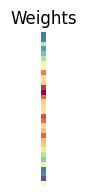

In [5]:
fig, ax = plt.subplots(figsize=(1,2))
plt.imshow(np.array([weights.sel(event=decision_event)[:,0]]).T, cmap='Spectral_r')
plt.axis("off")
plt.title('Weights')
plt.savefig("plots/weights.png", transparent=True, dpi=300)

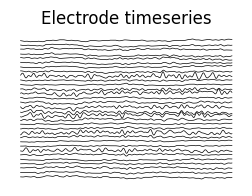

In [6]:
fig, ax = plt.subplots(figsize=(3,2))
xlim = int(1*sfreq)
plt.plot(epoch_data.isel(participant = 0, epochs=0, samples=range(xlim)).data.values.T + np.tile(np.arange(len(channels))*3e-5, (xlim,1)), color='k', lw=.5)
plt.axis("off")
plt.title('Electrode timeseries')
plt.savefig("plots/elecs.png", transparent=True, dpi=300)

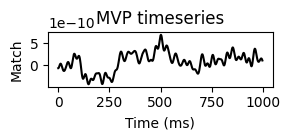

In [7]:
fig, ax = plt.subplots(figsize=(3,1.5))
xlim = int(1000/tstep)
plt.plot(np.arange(xlim)*tstep, epoch_data.isel(participant = 0, epochs = 0, samples=range(xlim)).data.values.T@weights.sel(event=decision_event).values, color='k')
plt.ylabel('Match')
plt.title('MVP timeseries')
plt.xlabel('Time (ms)')
plt.tight_layout()
plt.savefig("plots/timecourse.png", transparent=True, dpi=300)

In [8]:
contrasts = (np.linspace(0.034999999,0.9550001,10)*100)
color_cont_greys = {x: plt.cm.Greys(x/100) for x in contrasts}
color_cont_spd = {x: plt.cm.Reds(x/100) for x in contrasts}
color_cont_acc = {x: plt.cm.Blues(x/100) for x in contrasts}
color_sat = {'speed':color_cont_spd,'accuracy':color_cont_acc}

/tmp/ipykernel_264410/3280142422.py:35: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


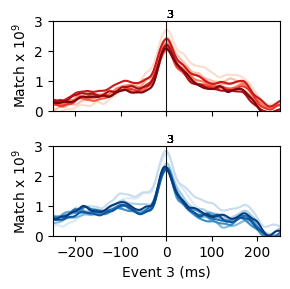

In [9]:
fig5 = plt.figure(constrained_layout=True, figsize=(3,3))

widths = [ 5]
heights = [.5, .5]
spec5 = fig5.add_gridspec(ncols=1, nrows=2, width_ratios=widths,
                          height_ratios=heights)

baseline = np.array([-.25] )*sfreq
n_samples = np.array([.25])*sfreq
labels = ['Low','High']
for c, SAT in enumerate(["speed","accuracy"]):
    for i, event in enumerate([decision_event]):
        ax = fig5.add_subplot(spec5[c, i])
        for j, cont in enumerate(list(zip(contrasts, np.roll(contrasts, -1)))[:-1]):
            data_left_sp = data.where((data.stimulus.astype(int) > cont[0]) & (data.stimulus.astype(int) < cont[1])& (data.condition == SAT), drop=True).dropna('trial_x_participant', how="all")
            if SAT == 'accuracy':
                ax.tick_params(bottom=True, labelbottom=True, left=True, labelleft=True)
                ax.set_xlabel(f'Event {event+1} (ms)')
                ax.set_ylabel(r'$\mu$V')
            else:
                ax.tick_params(bottom=True, labelbottom=False, left=True, labelleft=True)
                ax.set_ylabel(r'$\mu$V')
            centered = hmp.utils.centered_activity(data_left_sp, times_sp, channels,
                event=event+1, n_samples=n_samples[i], cut_before_event=0, cut_after_event=0,
                baseline=baseline[i])
            timecourse = centered.data.unstack().mean(['trials']).mean('participant').data.T@weights.sel(event=decision_event).values
            ax.plot(centered.samples*tstep, timecourse*1e10,
                                 color=color_sat[SAT][cont[1]])
            ax.vlines(0, 0, 3, color='k', alpha=.25, lw=.75)
            ax.text(0, 3.1, event+1, fontsize=8)
            ax.set_xlim(baseline[i]*tstep, n_samples[i]*tstep)
            ax.set_ylim(0,3) 
            ax.set_ylabel(r'Match x $10^{9}$')
            
plt.tight_layout()
plt.savefig('plots/ERPs_Ev2.png',dpi=300,transparent=True,bbox_inches='tight')

/tmp/ipykernel_264410/2933159883.py:36: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


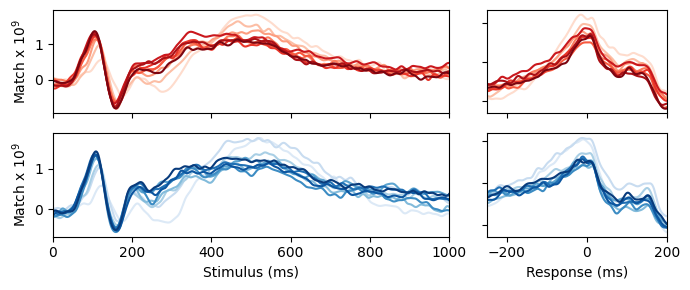

In [10]:
fig5 = plt.figure(constrained_layout=True, figsize=(7,3))

widths = [11, 5]
heights = [.5, .5]
spec5 = fig5.add_gridspec(ncols=2, nrows=2, width_ratios=widths,
                          height_ratios=heights)
baseline = np.array([ 0, -.25] )*sfreq
n_samples = np.array([1, .2])*sfreq
for c, SAT in enumerate(["speed","accuracy"]):
    for i, event in enumerate([0, 4]):
        ax = fig5.add_subplot(spec5[c, i])
        for cont in list(zip(contrasts, np.roll(contrasts, -1)))[:-1]:
            data_left_sp = data.where((data.stimulus.astype(int) > cont[0]) & (data.stimulus.astype(int) < cont[1])& (data.condition == SAT), drop=True).dropna('trial_x_participant', how="all")
            if SAT == 'accuracy':
                ax.tick_params(bottom=True, labelbottom=True, left=True, labelleft=True)
                if i == 0:
                    ax.set_xlabel('Stimulus (ms)')
                else:
                    ax.set_xlabel('Response (ms)')
            else:               
                ax.tick_params(bottom=True, labelbottom=False, left=True, labelleft=True)
            if i == 0:
                ax.set_ylabel(r'Match x $10^{9}$')
                
            else:
                ax.tick_params(labelleft=False)
            centered = hmp.utils.centered_activity(data_left_sp, times_sp, channels,
                event=event, n_samples=n_samples[i], cut_before_event=0, cut_after_event=0,
                baseline=baseline[i])
            timecourse = centered.data.unstack().mean(['trials']).mean('participant').data.T@weights.sel(event=decision_event).values
            ax.plot(centered.samples*tstep, timecourse*1e10,
                                 color=color_sat[SAT][cont[1]])
                
            ax.set_xlim(baseline[i]*tstep, n_samples[i]*tstep)
            # ax.set_ylim(-1.5,2.75)            
plt.tight_layout()
plt.savefig('plots/ERPs.png',dpi=300,transparent=True,bbox_inches='tight')

In [11]:
contrasts_bin = (np.linspace(0.034999999,0.9550001,3)*100)
color_cont_grey_bin = {x: plt.cm.Greys(x/100) for x in contrasts_bin}
color_cont_spd_bin = {x: plt.cm.Reds(x/100) for x in contrasts_bin}
color_cont_acc_bin = {x: plt.cm.Blues(x/100) for x in contrasts_bin}
color_sat_bin = {'speed':color_cont_spd_bin,'accuracy':color_cont_acc_bin}

Using a threshold of 2.059539
stat_fun(H1): min=-1.5089149724353483 max=2.9511889989822215
Running initial clustering …
Found 1 cluster


  0%|          | Permuting : 0/1023 [00:00<?,       ?it/s]

Using a threshold of 2.059539
stat_fun(H1): min=-1.5089149724353483 max=1.5394859351443395
Running initial clustering …
Found 0 clusters


/tmp/ipykernel_264410/4725383.py:55: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  test_stats = permutation_cluster_1samp_test(diff)


Using a threshold of 2.063899
stat_fun(H1): min=-1.5557013642149848 max=3.02839234628844
Running initial clustering …
Found 1 cluster


  0%|          | Permuting : 0/1023 [00:00<?,       ?it/s]

Using a threshold of 2.063899
stat_fun(H1): min=-1.5557013642149848 max=1.6553997358507342
Running initial clustering …
Found 0 clusters


/tmp/ipykernel_264410/4725383.py:55: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  test_stats = permutation_cluster_1samp_test(diff)
/tmp/ipykernel_264410/4725383.py:62: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


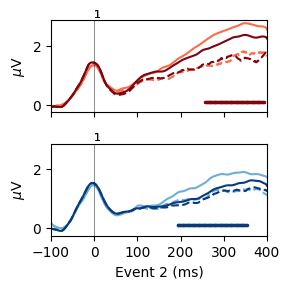

In [12]:
fig5 = plt.figure(constrained_layout=True, figsize=(3,3))

widths = [ 5]
heights = [.5, .5]
spec5 = fig5.add_gridspec(ncols=1, nrows=2, width_ratios=widths,
                          height_ratios=heights)

baseline = np.array([-.1] )*sfreq
n_samples = np.array([.4])*sfreq
labels = ['Low','High']
for c, SAT in enumerate(["speed","accuracy"]):
    for i, event in enumerate([1]):
        list_activ, list_activ_without = [],[]
        ax = fig5.add_subplot(spec5[c, i])
        for j, cont in enumerate(list(zip(contrasts_bin, np.roll(contrasts_bin, -1)))[:-1]):
            data_left_sp = data.where((data.stimulus.astype(int) > cont[0]) & (data.stimulus.astype(int) < cont[1])& (data.condition == SAT), drop=True).dropna('trial_x_participant', how="all")
            if SAT == 'accuracy':
                ax.tick_params(bottom=True, labelbottom=True, left=True, labelleft=True)
                ax.set_xlabel(f'Event 2 (ms)')
                ax.set_ylabel(r'$\mu$V')
            else:
                ax.tick_params(bottom=True, labelbottom=False, left=True, labelleft=True)
                ax.set_ylabel(r'$\mu$V')
            centered = hmp.utils.centered_activity(data_left_sp, times_sp, ['CP1','CP2'],
                event=event+1, n_samples=n_samples[i], cut_before_event=0, cut_after_event=0,
                baseline=baseline[i], event_width=100/tstep)
            list_activ.append(centered.data.unstack().mean(['trials','channel']).data.T)
            timecourse = centered.data.unstack().mean(['trials','channel']).mean('participant').data.T
            ax.plot(centered.samples*tstep, timecourse*1e6,
                                 color=color_sat_bin[SAT][cont[1]], label="(%s,%s)"%(int(np.round(cont[0])),int(np.round(cont[1]))))
            centered = hmp.utils.centered_activity(data_left_sp, times_sp, ['CP1','CP2'],
                event=event+1, n_samples=n_samples[i], cut_before_event=0, cut_after_event=1,
                baseline=baseline[i], event_width=100/tstep)
            list_activ_without.append(centered.data.unstack().mean(['trials','channel']).data.T)
            
            timecourse = centered.data.unstack().mean(['trials','channel']).mean('participant').data.T
            ax.plot(centered.samples*tstep, timecourse*1e6, ls='--',
                                 color=color_sat_bin[SAT][cont[1]], label="%s"%labels[j])

            ax.vlines(0, -0.25, 2.95, color='k', alpha=.25, lw=.75)
            ax.text(0, 2.95, event, fontsize=8)
            ax.set_xlim(baseline[i]*tstep, n_samples[i]*tstep)
            ax.set_ylim(-0.25,2.85)
        diff = list_activ[0] - list_activ[1]
        diff = diff[np.isfinite(diff[:,0]),:]
        test_stats = permutation_cluster_1samp_test(diff)
        if isinstance(test_stats[1], list):
            sig = np.concatenate([arr[0] for arr in test_stats[1]])
        else: sig =  test_stats[1]
        if len(sig ) > 0:
            ax.plot((centered.samples*tstep)[sig], np.repeat(.1, len(sig)), '.', color=color_sat_bin[SAT][cont[1]], markersize=3)
        if len(list_activ_without) > 0:
            diff = list_activ_without[0] - list_activ_without[1]
            diff = diff[np.isfinite(diff[:,0]),:]
            test_stats = permutation_cluster_1samp_test(diff)
            if isinstance(test_stats[1], list):
                sig = np.concatenate([arr[0] for arr in test_stats[1]])
            else: sig =  test_stats[1]
            if len(sig ) > 0:
                ax.plot((centered.samples*tstep)[sig], np.repeat(.15, len(sig)), 'x', color=color_sat_bin[SAT][cont[1]], markersize=3)
            
plt.tight_layout()
plt.savefig('plots/ERPs_CPP.png',dpi=300,transparent=True,bbox_inches='tight')